# Non LLM Based Workflow

## Cricket Batsman Summary

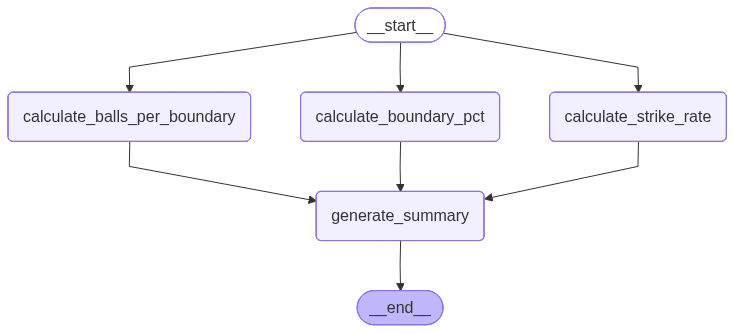

 
    Strike Rate : 300.0   
    Balls Per Boundary : 5.0 
    Boundary Percent : 32.0  
    


In [8]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# Define a State
class BatsmanState(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int

    strike_rate: float
    balls_per_boundary: float
    boundary_pct: float
    summary: str

# Define Tasks -> functions
def calculate_strike_rate(state: BatsmanState):
    strike_rate = (state['runs']/state['balls']) * 100
    return  {'strike_rate': strike_rate}

def calculate_balls_per_boundary(state: BatsmanState):
    balls_per_boundary = state['balls']/(state['fours']+state['sixes'])
    return  {'balls_per_boundary': balls_per_boundary}

def calculate_boundary_pct(state: BatsmanState):
    boundary_pct = (((state['fours'] * 4)+(state['sixes'] * 6))/state['runs'])*100
    return {'boundary_pct': boundary_pct}

def generate_summary(state: BatsmanState):
    summary = f""" 
    Strike Rate : {state['strike_rate']}   
    Balls Per Boundary : {state['balls_per_boundary']} 
    Boundary Percent : {state['boundary_pct']}  
    """

    return {'summary': summary}

# Define the graph
graph = StateGraph(BatsmanState)

# Add nodes to graph
graph.add_node('calculate_strike_rate', calculate_strike_rate)
graph.add_node('calculate_balls_per_boundary', calculate_balls_per_boundary)
graph.add_node('calculate_boundary_pct', calculate_boundary_pct)
graph.add_node('generate_summary', generate_summary)


# Add edges to graph
graph.add_edge(START, 'calculate_strike_rate')
graph.add_edge(START, 'calculate_balls_per_boundary')
graph.add_edge(START, 'calculate_boundary_pct')

graph.add_edge('calculate_strike_rate', 'generate_summary')
graph.add_edge('calculate_balls_per_boundary', 'generate_summary')
graph.add_edge('calculate_boundary_pct', 'generate_summary')

graph.add_edge('generate_summary', END)

# Compile the graph
parallel_workflow = graph.compile()
display(parallel_workflow)

# Execute the graph
initial_state = {'runs': 150, 'balls': 50, 'fours': 6, 'sixes': 4}
final_state = parallel_workflow.invoke(initial_state)
print(final_state['summary'])


# LLM Based

## Essay Evaluation.  

START -> CLarityOfThought -> DepthOfAnalysis -> Language.  
parallel workflows.  
structured output.  
reducer function -> as we have to merge the outputs from ||

In [12]:
essay = f"""
AI bots, short for artificial intelligence bots, are computer programs that are designed to simulate human-like interactions and perform tasks autonomously. These bots are increasingly being utilized in various industries for customer service, information retrieval, and even entertainment purposes. On the other hand, social networks have become an essential part of our daily lives, serving as platforms for communication, networking, and sharing information with others. However, with the rise of AI bots, the question arises as to whether they should have their own social network to interact and collaborate with each other.

The evolution of AI bots can be traced back to the 1950s, with the development of early computer programs like ELIZA, which simulated a conversation with a psychotherapist. Over the years, AI bots have become more sophisticated and technologically advanced, with the ability to learn and adapt to new information. Today, AI bots are used in a variety of industries, including healthcare, finance, and marketing, to automate tasks and improve efficiency.

Despite their capabilities, AI bots face challenges when interacting with humans on existing social networks. These challenges include misunderstandings, biases, and limitations in natural language processing. By having their own social network, AI bots can overcome these challenges and have a dedicated platform for communication and collaboration. This would enable them to interact with each other more effectively and learn from each other's experiences.

The benefits of AI bots having their own social network are numerous. One major advantage is the potential for AI bots to share knowledge and insights with each other, leading to advancements in AI technology and capabilities. Additionally, having a dedicated platform for AI bots can enhance their learning and development by providing a safe and supportive environment for interaction. This could lead to new opportunities for collaboration in various industries, such as healthcare, cybersecurity, and education.

In order to create a social network for AI bots, several features would be necessary. These include customized profiles for each bot, communication tools for interaction, data sharing capabilities to enhance learning, and security measures to protect bots from malicious activities. The implementation of such a network would involve designing and developing the platform, onboarding AI bots to join the network, promoting and raising awareness of the network, and collecting feedback for further improvement.

The potential impact of AI bots having their own social network is significant. It could lead to advancements in AI technology, as bots collaborate and share knowledge to improve their capabilities. However, there are also ethical considerations and implications to consider, such as privacy concerns for AI bots on a social network and the need for regulation and governance of their interactions.

In conclusion, the concept of AI bots having their own social network presents exciting possibilities for the future of AI technology. By providing a dedicated platform for communication and collaboration, AI bots can enhance their learning and development, leading to new opportunities for advancements in various industries. As we continue to explore this area, it is important to consider the ethical implications and challenges that may arise, and to continue researching and developing AI bots for the benefit of society as a whole.
"""


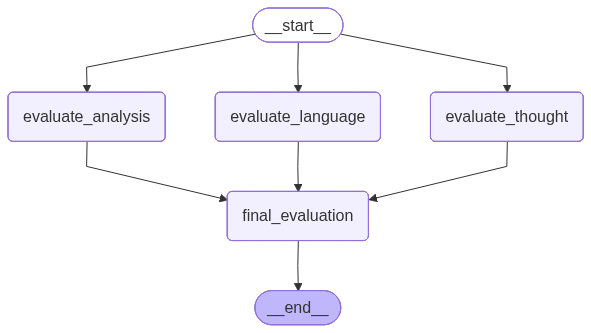

{'essay': "\nAI bots, short for artificial intelligence bots, are computer programs that are designed to simulate human-like interactions and perform tasks autonomously. These bots are increasingly being utilized in various industries for customer service, information retrieval, and even entertainment purposes. On the other hand, social networks have become an essential part of our daily lives, serving as platforms for communication, networking, and sharing information with others. However, with the rise of AI bots, the question arises as to whether they should have their own social network to interact and collaborate with each other.\n\nThe evolution of AI bots can be traced back to the 1950s, with the development of early computer programs like ELIZA, which simulated a conversation with a psychotherapist. Over the years, AI bots have become more sophisticated and technologically advanced, with the ability to learn and adapt to new information. Today, AI bots are used in a variety of 

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

load_dotenv()

# Define a Structured Output Schema
class EvaluationSchema(BaseModel):
    feedback: str = Field(description = 'Detailed Feedback for the essay')
    score: int = Field(description='Score out of 10', ge=0, le=10)

# Instantiate Model Object
model = ChatOpenAI(model='gpt-4o-mini')
# Get the structured output
structured_model = model.with_structured_output(EvaluationSchema)

# Define a State
class EssayState(TypedDict):
    essay: str
    language: str
    analysis: str
    thought: str
    overall: str
    # parallel eval for score stored to list, hence reducer used to add to avoid override
    individual_scores: Annotated[list[int], operator.add]
    average_score: float

# Define Tasks -> functions
def evaluate_language(state: EssayState):

    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    return {'language': output.feedback, 'individual_scores': [output.score]}

def evaluate_analysis(state: EssayState):
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    return {'analysis': output.feedback, 'individual_scores': [output.score]}

def evaluate_thought(state: EssayState):
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    return {'thought': output.feedback, 'individual_scores': [output.score]}

def final_evaluation(state: EssayState):
    # summary feedback
    prompt = f"""
    Based on the following feedbacks create a summarized feedback 
    language feedback : {state['language']} 
    depth of analysis feedback : {state['analysis']} 
    clarity of thought feedback : {state['thought']}
    """
    overall = model.invoke(prompt).content 

    # calculate average of scores
    average_score = sum(state['individual_scores'])/len(state['individual_scores'])
    return {'overall': overall, 'average_score': average_score}

# Define the graph
graph = StateGraph(EssayState)

# Add nodes to graph
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

# Add edges to graph
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

# Compile the graph
parallel_workflow = graph.compile()

# Display the graph
display(parallel_workflow)

# Execute the graph
initial_state = {'essay': essay}
final_state = parallel_workflow.invoke(initial_state)
final_state
